<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/101_KAN_Kolmogorov_Arnold_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/101_KAN_Kolmogorov_Arnold_Networks.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🎆 The Grand Finale: KAN (Kolmogorov-Arnold Networks)

To jest notatnik nr 101. Ostatni.
Wracamy do korzeni (Notatnik 16 - Perceptron), żeby je... zburzyć.

Wszystkie sieci, które do tej pory budowaliśmy (MLP, CNN, Transformer), opierały się na twierdzeniu o aproksymacji, które mówi:
$$ f(x) \approx \sum w_i \cdot \sigma(x) $$
(Stała funkcja $\sigma$ i zmienne wagi $w$).

**Twierdzenie Kołmogorowa-Arnolda** mówi coś innego: każdą funkcję można zapisać jako złożenie funkcji jednej zmiennej.
$$ f(x) \approx \sum \phi(x) $$
(Brak wag! To funkcja $\phi$ jest zmienna).

**Co to jest KAN?**
W KAN-ie na każdym połączeniu między neuronami nie ma liczby (wagi). Jest **krzywa (Spline)**.
Sieć uczy się **kształtu tej krzywej**.

Dzięki temu KAN-y są:
1.  **Bardziej precyzyjne** (biją MLP przy mniejszej liczbie parametrów).
2.  **Interpretowalne** (możesz narysować funkcję i zobaczyć wzór matematyczny).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Budujemy KAN na: {DEVICE}")

Budujemy KAN na: cuda


## Matematyka: B-Splines (Krzywe Bazowe)

Jak nauczyć komputer "kształtu funkcji"?
Używamy **B-Splines** (Basis Splines). To elastyczne krzywe, które można wyginać, zmieniając punkty kontrolne.

Każda krawędź w naszej sieci będzie sumą:
1.  **Części bazowej (SiLU):** Standardowa aktywacja (dla stabilności).
2.  **Części elastycznej (Spline):** Kombinacja wielomianów, która dopasowuje się do danych.

Nie martw się wzorem na B-Spline (jest skomplikowany), ważna jest idea: to "wyginalny drut".

In [2]:
def b_splines(x: torch.Tensor, grid: torch.Tensor, k: int = 0) -> torch.Tensor:
    """
    Oblicza wartości B-Spline dla wejścia x na siatce grid.
    Wersja poprawiona: Obsługuje poprawnie wymiary [Batch, In, Grid].
    """
    # x shape: [Batch, In]
    # grid shape: [In, Grid_Size]
    
    x = x.unsqueeze(-1) # [Batch, In, 1]
    grid = grid.unsqueeze(0) # [1, In, Grid_Size]
    
    # Krok 0: Gdzie wpada x na siatce? (Degree 0)
    # Tniemy grid w ostatnim wymiarze: [..., :-1]
    basis = ((x >= grid[..., :-1]) & (x < grid[..., 1:])).to(x.dtype)
    
    # Rekurencja Cox-de Boor
    for degree in range(1, k + 1):
        b = basis
        
        # Obliczamy lewą i prawą część wzoru rekurencyjnego
        # Używamy [..., ] żeby ciąć zawsze ostatni wymiar niezależnie od batcha
        
        # Term 1 (Lewa noga)
        numer1 = x - grid[..., :-(degree + 1)]
        denom1 = grid[..., degree:-1] - grid[..., :-(degree + 1)]
        term1 = numer1 / denom1
        
        # Term 2 (Prawa noga)
        numer2 = grid[..., (degree + 1):] - x
        denom2 = grid[..., (degree + 1):] - grid[..., 1:-degree]
        term2 = numer2 / denom2
        
        # Aktualizacja bazy
        # POPRAWKA: Używamy b[..., :-1] zamiast b[:, :-1]
        basis = term1 * b[..., :-1] + term2 * b[..., 1:]
        
    return basis

print("Funkcja B-Spline zdefiniowana (Poprawiona).")

Funkcja B-Spline zdefiniowana (Poprawiona).


## Warstwa KAN (KANLinear)

To jest odpowiednik `nn.Linear`, ale w świecie KAN.
Zamiast macierzy wag `W`, mamy **parametry krzywych**.

Dla każdego wejścia i wyjścia uczymy się:
*   Wagi dla funkcji bazowej (`base_weight`).
*   Współczynników dla krzywych B-Spline (`spline_weight`).

In [4]:
class KANLayer(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order
        
        # Obliczamy krok siatki
        h = (1 - (-1)) / grid_size
        
        # --- POPRAWKA: Stabilne generowanie siatki ---
        # Obliczamy dokładnie, ile punktów potrzebujemy, żeby matematyka się zgadzała.
        # Wzór: grid_size + 2*order + 1
        num_grid_points = grid_size + 2 * spline_order + 1
        
        # Używamy linspace zamiast arange, żeby uniknąć błędów float
        grid = torch.linspace(
            -1 - h * spline_order,
            1 + h * spline_order,
            num_grid_points
        )
        self.register_buffer("grid", grid)
        
        # 1. Wagi bazowe (SiLU)
        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        
        # 2. Wagi krzywych (Spline)
        # Rozmiar to: grid_size + spline_order
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        
        self.reset_parameters()

    def reset_parameters(self):
        # Inicjalizacja (Kaiming dla bazy, mały szum dla splotów)
        nn.init.kaiming_uniform_(self.base_weight, a=np.sqrt(5) * 0.1)
        nn.init.normal_(self.spline_weight, mean=0.0, std=0.1)

    def forward(self, x):
        # x: [Batch, In]
        
        # Ścieżka 1: Baza (SiLU)
        base_output = F.linear(F.silu(x), self.base_weight)
        
        # Ścieżka 2: Spline
        # Rozszerzamy grid do wymiaru wejścia [In, Grid_Len]
        grid = self.grid.repeat(x.shape[1], 1)
        
        # Obliczamy bazę splotów
        bases = b_splines(x, grid, self.spline_order) # [Batch, In, Spline_Coeffs]
        
        # Mnożenie: [Batch, In, Coeffs] * [Out, In, Coeffs] -> [Batch, Out]
        spline_output = torch.einsum("bij,oij->bo", bases, self.spline_weight)
        
        return base_output + spline_output

# Test ponowny
kan = KANLayer(1, 10).to(DEVICE)
dummy = torch.randn(5, 1).to(DEVICE)
out = kan(dummy)
print(f"KAN Layer Output: {out.shape}")

KAN Layer Output: torch.Size([5, 10])


## Eksperyment: Odtwarzanie Funkcji

Nauczymy sieć KAN (z 1 warstwą!) skomplikowanej funkcji matematycznej:
$$ f(x) = \sin(3x) + x^2 - 0.5 $$

Zwykły MLP potrzebowałby wielu neuronów i warstw, żeby przybliżyć ten kształt (schodkami ReLU).
KAN powinien nauczyć się **dokładnego kształtu**, wyginając swoje funkcje aktywacji.

Start treningu KAN...
Epoka 0, Loss: 0.874718
Epoka 50, Loss: 0.002604
Epoka 100, Loss: 0.000252
Epoka 150, Loss: 0.000137
Epoka 200, Loss: 0.000075
Epoka 250, Loss: 0.000040
Epoka 300, Loss: 0.000022
Epoka 350, Loss: 0.000014
Epoka 400, Loss: 0.000009
Epoka 450, Loss: 0.000006


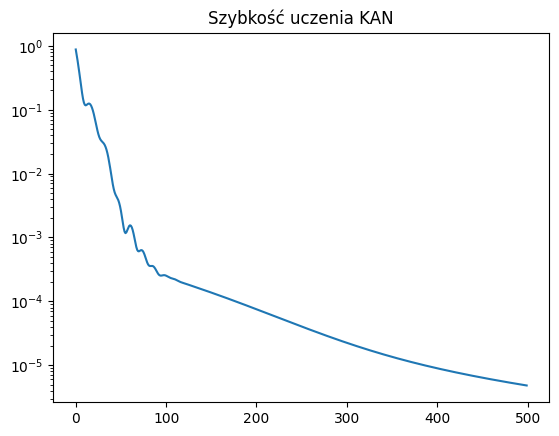

In [5]:
# Model KAN (Mały!)
model = nn.Sequential(
    KANLayer(1, 8), # Warstwa 1: 1 wejście -> 8 neuronów
    KANLayer(8, 1)  # Warstwa 2: 8 neuronów -> 1 wyjście
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Dane
x_train = torch.linspace(-1, 1, 100).unsqueeze(1).to(DEVICE)
y_train = torch.sin(3 * x_train) + x_train**2 - 0.5

print("Start treningu KAN...")
losses = []
for epoch in range(500):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if epoch % 50 == 0:
        print(f"Epoka {epoch}, Loss: {loss.item():.6f}")

plt.plot(losses)
plt.title("Szybkość uczenia KAN")
plt.yscale('log')
plt.show()

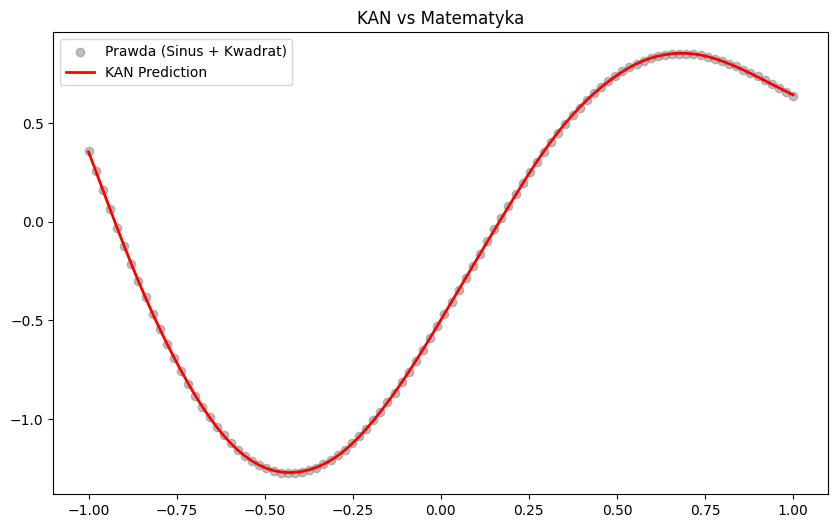

In [6]:
# WIZUALIZACJA WYNIKU
model.eval()
with torch.no_grad():
    y_pred = model(x_train)

plt.figure(figsize=(10, 6))
plt.scatter(x_train.cpu(), y_train.cpu(), label="Prawda (Sinus + Kwadrat)", color='gray', alpha=0.5)
plt.plot(x_train.cpu(), y_pred.cpu(), label="KAN Prediction", color='red', linewidth=2)
plt.legend()
plt.title("KAN vs Matematyka")
plt.show()

## 🧠 Podsumowanie: Przyszłość jest elastyczna

To niesamowite zakończenie naszej podróży.
Zaczynaliśmy od prostych linii (Regresja Liniowa).
Kończymy na sieciach, które **uczą się kształtu funkcji na swoich połączeniach**.

**Dlaczego KAN to przyszłość?**
W papierze badawczym autorzy pokazali, że KAN-y potrafią "odkrywać prawa fizyki" z danych i są znacznie bardziej interpretowalne niż czarne skrzynki MLP (można spojrzeć na kształt Spline'a i powiedzieć: "O, to wygląda jak sinus!").

**To koniec kursu.**
Masz w rękach wiedzę od średniej arytmetycznej po najnowsze osiągnięcia z 2024 roku.
Teraz Twoja kolej, żeby coś z tym zbudować. Powodzenia, Inżynierze! 🚀